# PyMC

In an effort to compare and contrast vs numpyro, going to test out pymc and hopefully write up something longer to show the syntax differences and similarities, and recommend one for a beginner.

In [1]:
# Preamble
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# next, pymc specific setup
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We'll follow the same simulated data as in the [GLM:Linear Regression pymc docs](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)

In [2]:
# Simulate Data
np.random.seed(42)

size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(0, 0.5, size)

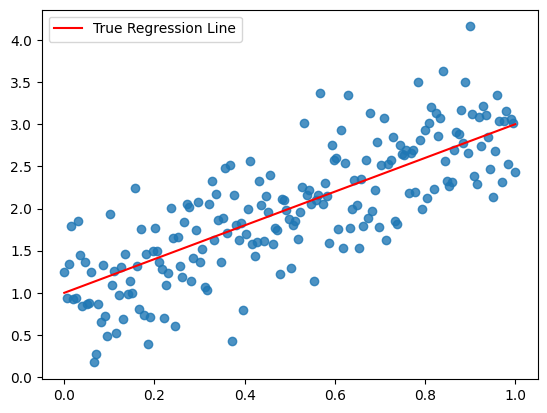

In [3]:
plt.scatter(x, y, alpha=0.8)
plt.plot(x, true_regression_line, c='r', label='True Regression Line')
plt.legend();

Model Estimation with `numpyro`

In [4]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

def numpyro_model(x, y):
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    intercept = numpyro.sample("intercept", dist.Normal(0,20))
    slope = numpyro.sample("slope", dist.Normal(0,20))

    # mu = intercept + slope*x
    mu = numpyro.deterministic('mu', intercept + slope * x)
    likelihood = numpyro.sample("y", dist.Normal(mu, sigma), obs=y)
    return likelihood

# 2. Run Inference engine to get posterior 
nuts_kernel = NUTS(numpyro_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=4)
# jax needs a rng key
rng_key = random.PRNGKey(seed = 42)
# running with the observations
mcmc.run(rng_key, 
         x=x, 
         y=y)
mcmc.print_summary()

/var/folders/29/f5j1jzy53gb1vyk06d20mz080000gq/T/ipykernel_67022/540768941.py:19: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=4)
sample: 100%|██████████| 2000/2000 [00:00<00:00, 8148.63it/s, 15 steps of size 3.25e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept      0.92      0.07      0.92      0.81      1.03   1794.24      1.00
      sigma      0.47      0.02      0.47      0.43      0.51   2060.87      1.00
      slope      2.11      0.11      2.11      1.92      2.28   1806.59      1.00

Number of divergences: 0


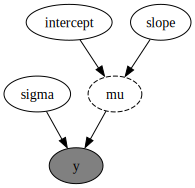

In [5]:
numpyro.render_model(numpyro_model, model_args=(x,y))

In [6]:
az.summary(mcmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.924,0.066,0.799,1.043,0.002,0.001,1787.0,1649.0,1.0
mu[0],0.924,0.066,0.799,1.043,0.002,0.001,1787.0,1649.0,1.0
mu[1],0.934,0.065,0.812,1.053,0.002,0.001,1789.0,1663.0,1.0
mu[2],0.945,0.065,0.823,1.063,0.002,0.001,1792.0,1673.0,1.0
mu[3],0.955,0.064,0.834,1.072,0.002,0.001,1795.0,1685.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[197],3.014,0.065,2.892,3.132,0.001,0.001,2677.0,2556.0,1.0
mu[198],3.025,0.065,2.902,3.143,0.001,0.001,2664.0,2556.0,1.0
mu[199],3.036,0.066,2.911,3.154,0.001,0.001,2652.0,2597.0,1.0
sigma,0.469,0.024,0.426,0.514,0.001,0.000,2112.0,2383.0,1.0


Model Estimation Syntax with pymc, takes about 5-9 sec.

In [7]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    mu = intercept + slope * x
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

The base `pymc` sampler takes like 6 sec on my local machine:

In [8]:
with model:
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(1000, nuts_sampler='pymc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can get some speedups by using a different sampler right off the bat. For instance, we can use the `numpyro` sampler (as long as the model is continous). On my machine, this results in a 3x speedup and completes in ~2 sec.

In [9]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.922,0.068,0.792,1.052,0.002,0.001,1792.0,2085.0,1.0
slope,2.114,0.117,1.895,2.340,0.003,0.002,1792.0,1999.0,1.0
sigma,0.469,0.023,0.429,0.513,0.000,0.000,2574.0,2118.0,1.0


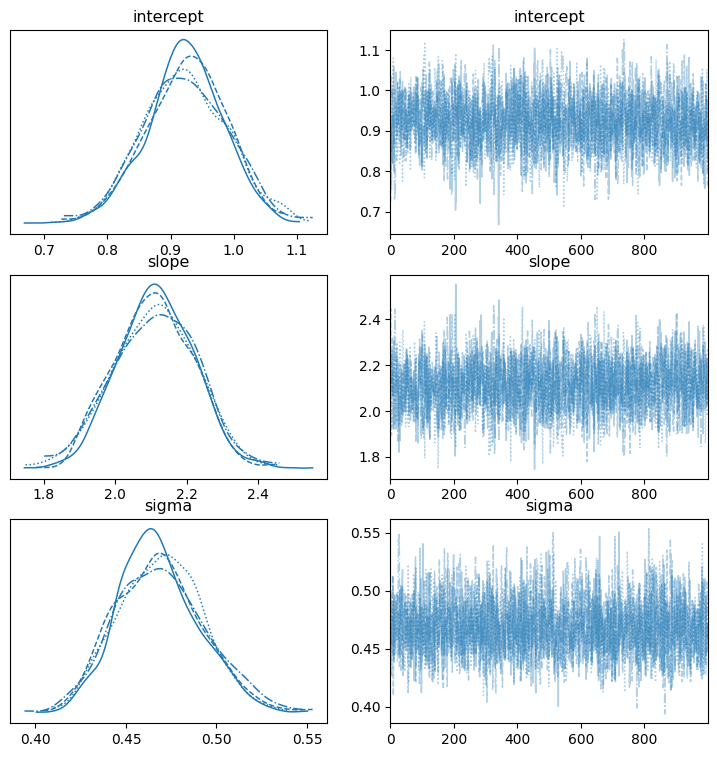

In [10]:
az.plot_trace(mcmc, var_names=['intercept', 'slope', 'sigma'], figsize=(9,9));

In [11]:
with model:
    # Note: must be continuous
    idata = pm.sample(1000, nuts_sampler='numpyro')

Compiling...
/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-FRV7Ufu--py3.10/lib/python3.10/site-packages/pymc/sampling/jax.py:678: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:00.516739
Sampling...
sample: 100%|██████████| 2000/2000 [00:00<00:00, 8051.92it/s, 3 steps of size 4.22e-01. acc. prob=0.91] 
Sampling time = 0:00:02.989082
Transforming variables...
Transformation time = 0:00:00.048573


The result is an `arviz.InferenceData` object that's essentially an `xarray.Dataset`

In [12]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [13]:
## get representative sample of posterior
posterior_samples = mcmc.get_samples()

# marginal aka posterior predictive
predictive = Predictive(numpyro_model, posterior_samples=posterior_samples)
posterior_predictive = predictive(random.PRNGKey(1), x=x, y=None)

In [14]:
nidata = az.from_numpyro(mcmc, posterior_predictive=posterior_predictive)
nidata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: xlabel='y_dim_0', ylabel='y'>]], dtype=object)

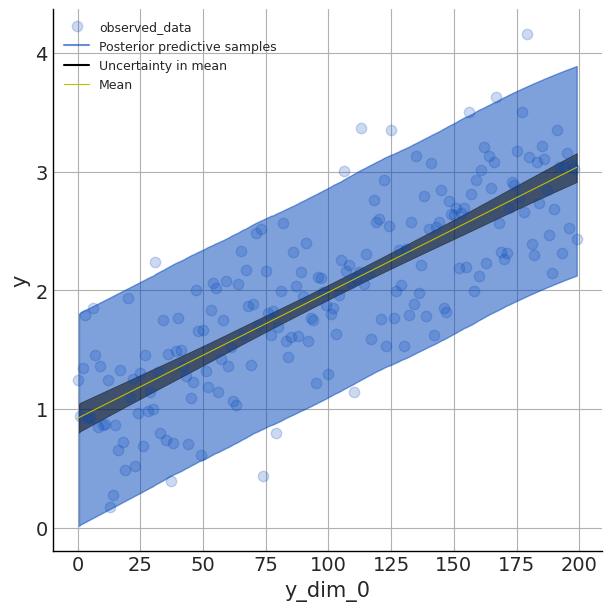

In [18]:
az.style.use('arviz-bluish')
az.plot_lm(y='y', idata=nidata, y_model='mu', kind_pp='hdi', kind_model='hdi', figsize=(6,6), textsize=9)

## Arviz

`Arviz` is the premier library for understanding and analyzing PPL inference results and supports multiple languages. Regardless of which PPL you choose, you'll likely be able to analyze the results using `Arviz`. 

First thing we want to show is to inspect a summary table of our regression coefficient estimates, using the `az.summary()` function:

In [16]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.925,0.066,0.812,1.058,0.002,0.001,1417.0,1678.0,1.0
slope,2.109,0.115,1.888,2.329,0.003,0.002,1406.0,1627.0,1.0
sigma,0.468,0.024,0.424,0.514,0.001,0.000,2098.0,2128.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

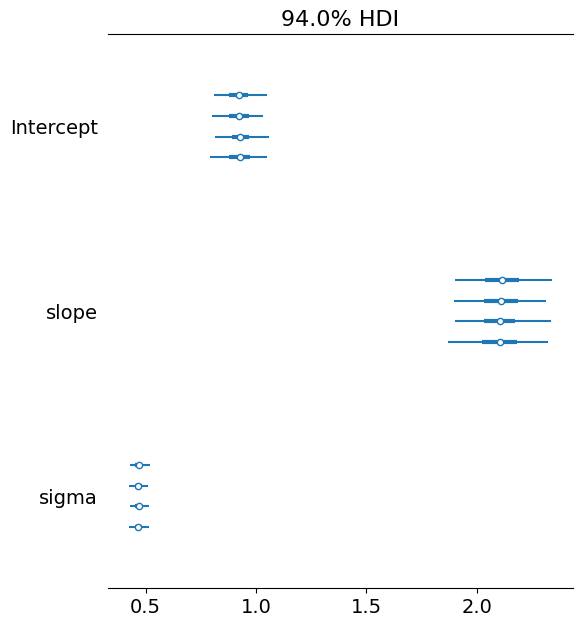

In [17]:
az.plot_forest(idata)